<a href="https://colab.research.google.com/github/PabloJRW/titanic-classifier/blob/main/notebooks/Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

In [2]:
# Importing the training set
df_train = pd.read_csv('../datasets/raw/train.csv')

X = df_train.drop('Survived', axis=1)
y = df_train.Survived

In [3]:
y_positive = df_train[df_train.Survived==1]['Survived'].count()
y_negative = df_train[df_train.Survived==0]['Survived'].count()

(y_positive / y_negative).round(2)

0.62

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print(df_train.shape)
print(X_train.shape)
print(X_val.shape)


(891, 12)
(668, 11)
(223, 11)


In [5]:
# loading the preprocessing pipeline
preprocessing_pipeline = joblib.load('preprocessing_pipeline.joblib')

In [6]:
X_train_pro = preprocessing_pipeline.fit_transform(X_train)
X_train_pro

array([[ 0.51413858,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.87644803,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.20866423,  0.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.23475286,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.88585626,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.44206958,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [14]:
# Búsqueda del modelo con mejor puntaje
# ===================================================================================

models = {'svc': SVC(), 
          'logistic': LogisticRegression(),
          'random_forest': RandomForestClassifier(),
          'knn': KNeighborsClassifier(),
          'gradient_b': GradientBoostingClassifier(),
          'naive_bayes': GaussianNB()}

n_models = len(models)
scores=[]
for name, model in models.items():
    y_train_pred = cross_val_predict(model, X_train_pro, y_train, cv=10)
    f1 = np.mean(f1_score(y_train, y_train_pred)).round(2)

    model_scores = np.array([name,f1])
    scores.append(np.array(model_scores))
          
scores_df = pd.DataFrame(scores, columns=['Model', 'F1']); scores_df.set_index('Model', inplace=True)
scores_df.sort_values(by='F1', ascending=False)

,F1
Model,
logistic,0.71
random_forest,0.7
gradient_b,0.7
svc,0.69
knn,0.68
naive_bayes,0.56


In [15]:
# Reporte de puntuaciones del modelo Random Forest
# ==============================================================================
rforest_clf = RandomForestClassifier(random_state=42)
y_pred = cross_val_predict(rforest_clf, X_train_pro, y_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[351  64]
 [ 84 169]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       415
           1       0.73      0.67      0.70       253

    accuracy                           0.78       668
   macro avg       0.77      0.76      0.76       668
weighted avg       0.78      0.78      0.78       668



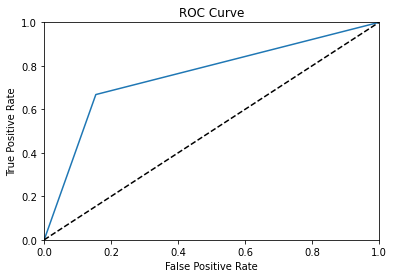

In [16]:
y_scores = cross_val_predict(rforest_clf, X_train_pro, y_train, cv=5, n_jobs=-1)
threshold = 0.5
y_with_thres = (y_scores > threshold)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

# Defining AUC function
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [17]:
# Area Under Curve
roc_auc_score(y_train, y_pred)

0.7568836611267205